<a href="https://colab.research.google.com/github/TopeOlafisoye/Analyzing-Historical-Stocks-Revenue-Data/blob/main/Keratoconus_Deep_Learning_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [ ]:
import tensorflow as tf 
import keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, LeakyReLU, Dense, Dropout
import matplotlib.pyplot as plt 
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import re
import matplotlib.pyplot as plt
import keras_ocr
import cv2
import math
import time

In [ ]:
!pip install keras_ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Data **Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#We have train/test so let's see how  it works

train_path = "/content/drive/MyDrive/Keratoconus/Train_Validation sets"
test_path = "/content/drive/MyDrive/Keratoconus/Independent Test Set"

In [ ]:
x = plt.imread("/content/drive/MyDrive/Keratoconus/Train_Validation sets/Keratoconus/case1/KCN_1_EC_A.jpg")
x.shape

(224, 224, 3)

In [ ]:
batch_size = 128
img_height = 180
img_width = 180

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [ ]:
train = datagen.flow_from_directory(train_path,target_size=(48,48),class_mode="sparse", seed=1, color_mode="grayscale")
test = datagen.flow_from_directory(test_path,target_size=(48,48),class_mode="sparse", seed=1, color_mode="grayscale")

Found 2388 images belonging to 3 classes.
Found 1050 images belonging to 3 classes.


In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2388 files belonging to 3 classes.
Using 1911 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2388 files belonging to 3 classes.
Using 477 files for validation.


In [ ]:
class_names = train.class_names
print(class_names)

['Keratoconus', 'Normal', 'Suspect']


##Data Visualization

Here are the first nine images from the training dataset.

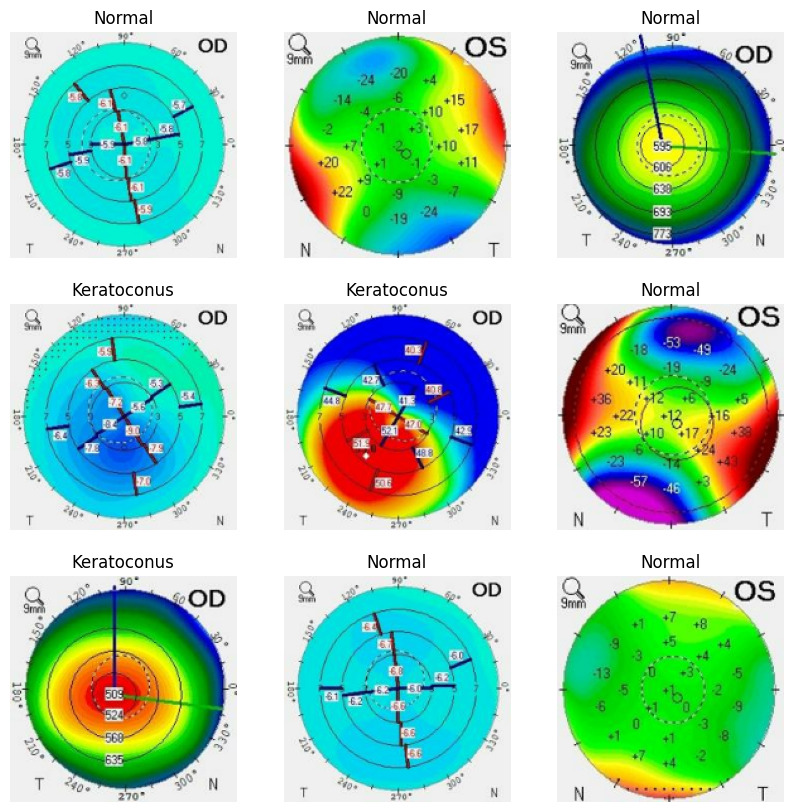

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 180, 180, 3)
(128,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on either of these tensors to convert them to a numpy.ndarray.

##Model Development

Standardize the data

The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling:

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

1.   Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
2.   Dataset.prefetch overlaps data preprocessing and model execution while training.



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Sequential Model
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,


]

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30)


Epoch 1/30
15/15 [==============================] - 114s 7s/step - loss: 0.9003 - accuracy: 0.6238 - val_loss: 0.6784 - val_accuracy: 0.7442
Epoch 2/30
15/15 [==============================] - 92s 6s/step - loss: 0.5960 - accuracy: 0.7760 - val_loss: 0.5293 - val_accuracy: 0.8050
Epoch 3/30
15/15 [==============================] - 91s 6s/step - loss: 0.4850 - accuracy: 0.8226 - val_loss: 0.4441 - val_accuracy: 0.8344
Epoch 4/30
15/15 [==============================] - 97s 6s/step - loss: 0.4001 - accuracy: 0.8493 - val_loss: 0.4208 - val_accuracy: 0.8491
Epoch 5/30
15/15 [==============================] - 93s 6s/step - loss: 0.3512 - accuracy: 0.8629 - val_loss: 0.4336 - val_accuracy: 0.8365
Epoch 6/30
15/15 [==============================] - 93s 6s/step - loss: 0.3359 - accuracy: 0.8707 - val_loss: 0.4417 - val_accuracy: 0.8574
Epoch 7/30
15/15 [==============================] - 96s 6s/step - loss: 0.3118 - accuracy: 0.8786 - val_loss: 0.3664 - val_accuracy: 0.8637
Epoch 8/30
15/15 [=

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 32)        9

if the validation accuracy is low compared to the training accuracy, this indicates that your model is overfitting

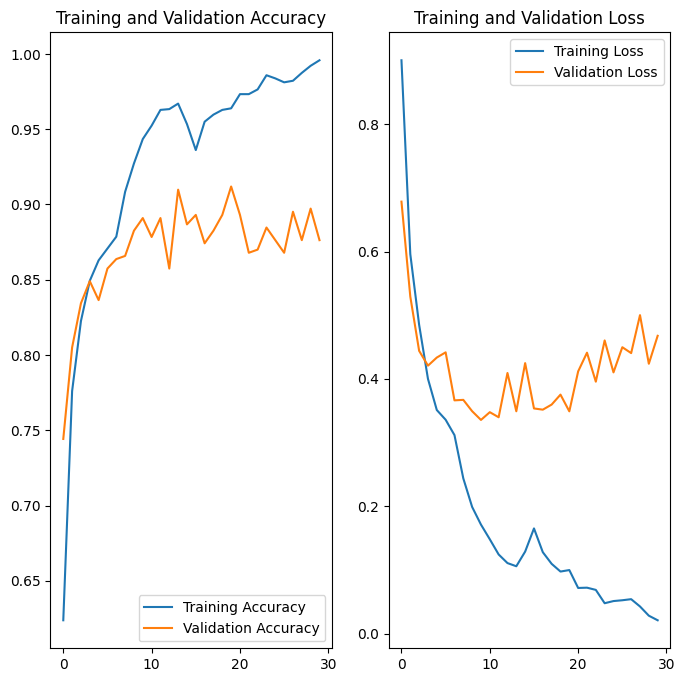

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=30
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('63.h5')

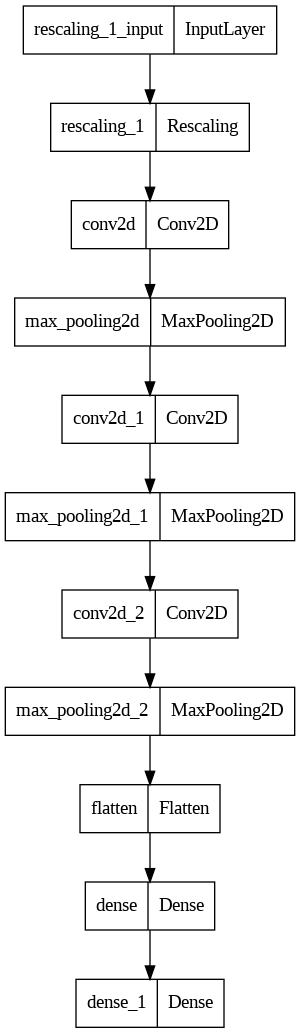

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False,
)